Check the intensity radial profile from frank fit, save it in a txt file, and compute the dust radii from the frank fit.

Dust radii with uncertainties are calculated in the frank_fit/frank_fit_bootstrap/ folder.

In [1]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.patheffects as patheffects
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

import frank
from frank.radial_fitters import FrankFitter
from frank.geometry import FixedGeometry
from frank.utilities import convolve_profile, sweep_profile
from frank.io import save_fit, load_sol
from frank.make_figs import make_full_fig
from gofish import imagecube  # for the CLEAN profile
sys.path.append('../frank_fit')
import diskdictionary as disk
from myutils import Jybeam_to_Jysr, Jysr_to_Tb, Jysr_to_Tb_err, Jysr_to_Tb_RJ, Jysr_to_Tb_RJ_err

from scipy.integrate import simpson

arcsec = 1/3600 * np.pi/180
deg = np.pi/180

In [2]:
target = 'AA_Tau'
target_label = disk.disk[target]['label']

In [5]:
# Load data
dat_uv = np.load(f'../data/{target}_continuum.vis.npz')
u, v, vis, weights = dat_uv['u'], dat_uv['v'], dat_uv['Vis'], dat_uv['Wgt']

# Load frank fit
sol = load_sol(f'../frank_fit/fits/{target}_frank_sol.obj')
r_frank = sol.r
Inu_frank = sol.I

distance_pc = disk.disk[target]['distance']

wavelength = np.loadtxt(f"../data/{target}_galario_uvtable.txt", max_rows=1, skiprows=2)
Tb_frank = Jysr_to_Tb(Inu_frank, 2.99792e10/wavelength)
r_frank_au =  r_frank * distance_pc

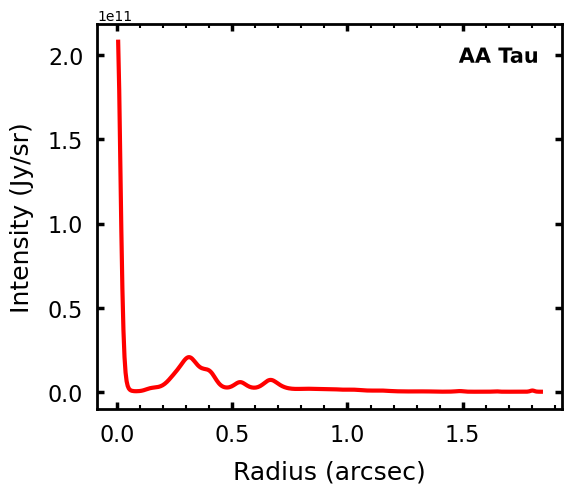

In [7]:
fig = plt.figure(figsize=(6,5))
ax =fig.add_subplot()

ax.plot(r_frank, Inu_frank, color='r', linewidth=3)

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

index_xticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Intensity (Jy/sr)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  

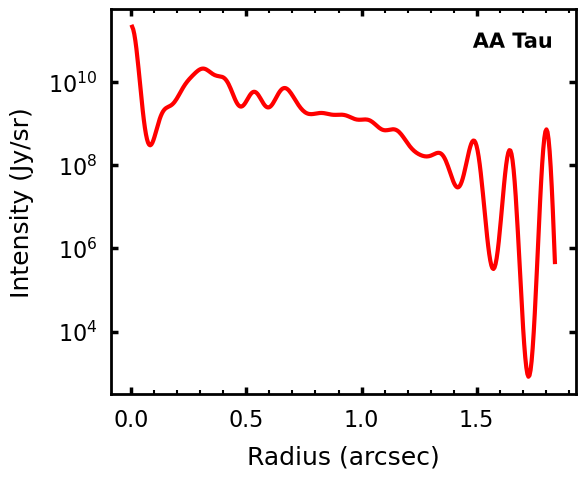

In [9]:
fig = plt.figure(figsize=(6,5))
ax =fig.add_subplot()

ax.plot(r_frank, Inu_frank, color='r', linewidth=3)

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

index_xticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

ax.set_yscale('log')

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Intensity (Jy/sr)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  

In [11]:
# frank profile
np.savetxt(f'{target}_frank_profile.txt',
           np.column_stack([r_frank, r_frank_au, Inu_frank, Tb_frank]),
           fmt='%10.6e', delimiter='\t',
           header=f'Intensity radial profile from the frank fit of {target}\nThe brightness temperature is computed using the full Planck law\nColumns:\tR(arcsec)\tR(au)\tIntensity(Jy/sr)\tBrightness_temperature(K)')

In [13]:
integrand  = 2*np.pi*r_frank*arcsec*Inu_frank
cumulative = np.cumsum(integrand)
norm_numerical_cumulative = np.cumsum(integrand)/np.amax(np.cumsum(integrand))

tot_flux =  simpson(integrand, r_frank*arcsec) * np.cos(disk.disk[target]['incl']*deg) *1e3
print(f'Total flux from frank fit profile = {tot_flux:.2f} mJy')

Total flux from frank fit profile = 191.49 mJy


In [15]:
cumulative_tot_flux = np.zeros(integrand.shape[0])
for i in range(1, integrand.shape[0]):
    cumulative_tot_flux[i] = simpson(integrand[:i], r_frank[:i]*arcsec) * np.cos(disk.disk[target]['incl']*deg) *1e3
    
norm_cumulative_tot_flux = cumulative_tot_flux / np.amax(cumulative_tot_flux)
R_68_arcsec = r_frank[np.where(norm_cumulative_tot_flux <= 0.68)[0][-1]]
R_90_arcsec = r_frank[np.where(norm_cumulative_tot_flux <= 0.90)[0][-1]]
R_95_arcsec = r_frank[np.where(norm_cumulative_tot_flux <= 0.95)[0][-1]]

R_68_au = R_68_arcsec * distance_pc
R_90_au = R_90_arcsec * distance_pc
R_95_au = R_95_arcsec * distance_pc

print(f'R_68 = {R_68_arcsec:.3g} arcsec = {(R_68_au):.3g} au\nR_90 = {R_90_arcsec:.3f} arcsec = {(R_90_au):.1f} au\nR_95 = {R_95_arcsec:.3f} arcsec = {(R_95_au):.1f} au')

R_68 = 0.685 arcsec = 92.2 au
R_90 = 1.035 arcsec = 139.4 au
R_95 = 1.177 arcsec = 158.6 au


In [17]:
np.savetxt(f'continuum_radii_frank_fit.txt',
           np.row_stack([[R_68_au, R_90_au, R_95_au], [R_68_arcsec, R_90_arcsec, R_95_arcsec]]),
           fmt='%.4g', delimiter='\t',
           header=f'Continuum radii from frank profile of {target}\nColumns: R68   R90   R95   \n1st row: au\n2nd row: arcsec'
          )

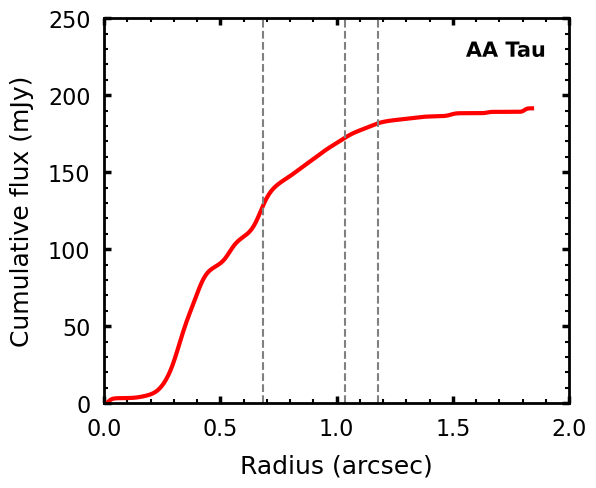

In [19]:
fig = plt.figure(figsize=(6,5))
ax =fig.add_subplot()

ax.plot(r_frank, cumulative_tot_flux, color='r', linewidth=3)

ax.text(0.95, 0.9, s=target_label,ha='right',
        transform=ax.transAxes, color='k', fontsize=15, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

ax.vlines((R_68_arcsec, R_90_arcsec, R_95_arcsec), 0, 1000, linestyle='dashed', color='gray', linewidth=1.5)

index_xticks = 0.5
ax.xaxis.set_major_locator(MultipleLocator(index_xticks))
ax.xaxis.set_minor_locator(MultipleLocator(index_xticks/5))

index_yticks = 50
ax.yaxis.set_major_locator(MultipleLocator(index_yticks))
ax.yaxis.set_minor_locator(MultipleLocator(index_yticks/5))

ax.set_xlim(0, 2.)
ax.set_ylim(0, 250)

ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=16, pad=10,width=2.5, length=5,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=16, pad=10,width=1.5, length=3,direction='in',color='k')

ax.set_xlabel('Radius (arcsec)', fontsize = 18, labelpad=10)
ax.set_ylabel('Cumulative flux (mJy)', fontsize = 18, labelpad=10)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)  